⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ 
# Disclaimer
👮🚨This notebook is sort of like my personal notes on this subject. It will be changed and updated whenever I have time to work on it. This is not meant to replace a thorough fluid substitution workflow. The intent here is make the major assumptions underlying the process of evaluating the affect of fluid fill on seismic response a little more clear, as well as provide references and background in literature for further study.🚨

At some point I will probably generalize this better so it can be used with real curves. For now it creates some fake blocked logs you can edit just to get a feel for how fluid sub works and how the different fluid fills might look in seismic. Also, currently the rocks are monomineralic. 

#### Important Note: 
The proper conditioning of logs, calibration of water saturations, reservoir selection for substituion, and rock and mineral parameter selection and calibration are extremely important to the reliability of a fluid substitution's output. These are good candidates for additional tutorials.

This tutorial is focused on the basic workflow from the geophysical perspective and therefore assumes the labor intensive petrophysical work mentioned above is both completed and reliable.

##### Notes for future:
* Incorporate a tuning section
* Put the whole thing in a function and see if I can get interact working so I can just use sliders to change parameters
* Generalize so real .las files can be loaded
* ~~Complete the implementation of the B&W fluid property equations~~
* ~~Fix a few of the hard-coded parts~~
* ~~Figure out why fill_betweenx isn't working~~

##### Come up and ask me questions on 7 if anything appears to be amiss! -Thomas

⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ ⚠ 

In [1]:
from collections import namedtuple
from scipy.stats import linregress
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
import bruges as b
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, interact_manual
import ipywidgets as widgets

from IPython.display import HTML

%matplotlib inline

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/tccw/geotools/master?filepath=tutorials%2FFluidSubstitution.ipynb)

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<font size="6" color="red">The raw code for this IPython notebook is hidden  by default for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</font>''')

# Porosity and Saturation effects on AVO

### Gassmann's Equations
Gassmann's equations (seen below) describes how the bulk modulus (ratio of pressure change to volume change) of a saturated rock changes as the saturating fluid changes. It provides a useful means for modeling how the seismic response of a formation may change for different filling fluids.

For a discussion of the origin and derivation of Gassmann's equations, see Berryman, 2000 (https://doi.org/10.1190/1.1444667) 

$$\textbf{Gassmann Equations}$$
$$\frac{K_{sat}}{K_{mineral} - K_{sat}} = \frac{K_{dry}}{K_{mineral} - K_{dry}} + \frac{K_{fluid}}{\phi(K_{mineral} - K_{fluid})}$$

$$\mu_{sat} = \mu_{dry}$$

$K_{dry} = \text{Dry rock bulk modulus}$  
$K_{mineral} = \text{Mineral bulk modulus}$  
$K_{sat} = \text{Saturated rock bulk modulus}$  
$K_{fluid} = \text{Fluid bulk modulus}$   
$\mu_{sat} = \text{Shear modulus of the saturated rock}$  
$\mu_{dry} = \text{Shear modulus of the dry rock}$

### Assumptions

1. Porous material is isotropic, elastic, monomineralic, and homogeneous
2. Pore sapce is well connected and in pressure equilibrium
3. Medium is a closed system with no pore fluid movement across boundaries
4. No checmical interaction between fluids and rock frame (i.e. no diagenetic processes)
5. Frequency effects are negligible when considering the measurements. Gassmann's equations are valid only for seismic frequencies (<100 Hz from Mavko, 1998).

These assumptions are often violated in real reservoirs. However, Gassmann's model is still generally the preferred model as it can be easily parameterized. A number of publications exist which suggest ways to modify inputs or assumptions to make these relationships more applicable to more variable rocks. A good general discussion of this can be found in Rob Simm's 2007 article "Practical Gassmann fluid substitution in sand/shale sequences [DOI: 10.3997//1365-2387.2007030](http://dreamcell-dev.co.uk/rpa/papers_downloads/RPA_simm_2007.pdf).

Below we will look at the Avseth et. al, 2006 fluid substitution workflow, which is used in this notebook.

#### Gassmann fluid substitution recipe from Avseth, 2006$^{[1]}$

$\textbf{Step 1:}$ Extract the dynamic bulk and shear moduli from $V_{p}^{(1)}$, $V_{s}^{(1)}$ , and $\rho^{(1)}$:

$K^{(1)}\ =\ \rho((V_{p}^{(1)})^2 - \frac{4}{3}(V_{s}^{(1)})^2)\\ \mu^{(1)}\ =\ \rho(V_{s}^{(1)})^2$

$\textbf{Step 2:}$ Apply Hassmann's relation to transform the bulk modulus:

$\frac{K_{sat}^{(2)}}{K_{mineral}\ -\ K_{sat}^{(2)}}\ -\ \frac{K_{fluid}^{(2)}}{\phi(K_{mineral}\ -\ K_{fluid}^{(2)})}\ =\ \frac{K_{sat}^{(1)}}{K_{mineral}\ -\ K_{sat}^{(1)}}\ -\ \frac{K_{fluid}^{(1)}}{\phi(K_{mineral}\ -\ K_{fluid}^{(1)})}$

$\textbf{Step 3:}$ Leave the shear modulus unchanged:

$\mu_{sat}^{(1)} = \mu_{sat}^{(2)}$

$\textbf{Step 4:}$ Remember to correct the bulk density for the fluid change:

$\rho^{(2)} = \rho^{(1)} + \phi(\rho_{fluid}^{(2)} - \rho_{fluid}^{(1)})$

$\textbf{Step 5:}$ Reassemble the velocities:

$V_p^{(2)} = \sqrt{\frac{K_{sat}^{(2)} + \frac{4}{3} \mu_{sat}^{(2)}}{\rho^{(2)}}}$

$V_s^{(2)} = \sqrt{\frac{\mu_{sat}^{(2)}}{\rho^{(2)}}}$

Below is a basic, blocked log example of Gassmann fluid substitution to help explore the affects of different fluids on the seismic response.

$^{[1]}$Avseth, Per; Mukerji, Tapan; Mavko, Gary. Quantitative Seismic Interpretation: Applying Rock Physics Tools to Reduce Interpretation Risk (Kindle Locations 582-584). Cambridge University Press. Kindle Edition. 

### Batzle and Wang fluid calculations

The most common, and likely most useful, method for calcualting the properties of fluids of varying composition, temperature, and pressure are empirical fluid equations from Batzle & Wang 1992. 

These functions take pressure in MPa and temperature in Centigrade. It outputs density in g/cc, velocity in m/s, and bulk modulus (K) in GPa.  

$\textbf{Equations for dead oil:}$

$API = \frac{141.5}{\rho_0} - 131.5$

$\rho_P = \rho_0 + (0.00277P - 1.71 \times 10^{-7}P^3)(\rho_0 - 1.15)^2 + 3.49 \times 10^{-4}P$

$\rho = \rho_P / [0.972 + 3.81 \times 10^{-4}(T + 17.78)^{1.175}]$

$V = 15450(77.1 + API)^{-1/2} - 3.7T + 4.64P + 0.0115(0.36API^{1/2} - 1)TP$

In [3]:
def batzle_wang_fluids(T, P, fl_flag , live=False, G=None, S=None, API=None, Rg=None):   
    '''
    Fluid property calculator based on Batlze & Wang, 1992 equations.
    
    
    Parameters
    ----------
    
    fl_flag options: 'oil', 'gas', 'brine'
    'live' argument controls if there is disolved as in the oil and how much
    
    T = temperature (deg C)
    P = pressure (MPa)
    G = Gas gravity (unitless) [For gas case and live oil case]
    S = salinity (weight fraction i.e. ppm/1e6) [For brine]
    API = API gravity of oil
    Rg = Disolved gas ratio (L/L) [For live oil and gassy brine]
    
    Returns bulk modulus is GPa, and density in kg/m^3
    '''
    if fl_flag == 'brine':
        #eqtn 27 - 29
        rhow = 1 + 1e-6 * (-80*T - 3.3*T**2 + 0.00175*T**3 + 489*P - 
                  2*T*P + 0.016*T**2 * P - 1.3e-5 * T**3 * P - 
                  0.333*P**2 - 0.002*T*P**2)
        rhobr = rhow + S*(0.668 + 0.44*S + 1e-6 * (300*P - 2400*P*S + 
                                           T*(80 + 3*T - 3300*S - 13*P + 47*P*S)))

        w = np.array([[1402.85, 1.524, 3.437e-3, -1.197e-5],
             [4.871, -0.0111, 1.739e-4, -1.628e-6],
             [-0.04783, 2.747e-4, -2.135e-6, 1.237e-8], 
             [1.487e-4, -6.503e-7, -1.455e-8, 1.327e-10], 
             [-2.197e-7, 7.987e-10, 5.230e-11, -4.614e-13]], dtype = float)

        vpW = sum(w[i][j]*np.power(P,i)*np.power(T,j) for i in range(4) for j in range(3))

        vpB = vpW + S*(1170 - 9.6*T + 0.055*T**2 - 8.5e-5 * T**3 + 2.6*P 
               - 0.0029*T*P - 0.0476*P**2)+ S**1.5 * (780 -10*P + 0.16*P**2) - 820*S**2 # eqtn 29
        
        if live == True:
            Kb = rhobr * vpB**2
            Kg = Kb / (1 + 0.0494 * Rg)
            K = Kg
        elif live == False:
            Kb = rhobr * vpB**2
            K = Kb/1e6

        props=(K,rhobr * 1e3)
    
    elif fl_flag == 'oil':
        rho0 = 141.5 / (API + 131.5) # eqtn 14
        rhoP = rho0 + (0.00277*P - 1.71e-7 * P**3)*(rho0 - 1.15)**2 + 3.49e-4 * P # eqtn 18

        if live == False:
            rho = rhoP / (0.972 + 3.81e-4 * (T + 17.78)**1.175) #etqn 19
            vp = 15450*(77.1 + API)**(-1/2) - 3.7 * T + 4.64 * P + 0.0115*(0.36 * API**(1/2) - 1) * T * P # eqtn 20b
        elif live == True:
            Bo = 0.972 + 0.00038*(2.4 * Rg * np.sqrt(G/rho0) + T + 17.8)**1.175 # Eqtn 23
            rhoPprime = (rho0/Bo) * (1 + 0.001*Rg)**(-1) # Eqtn 22
            rho = (rho0 + 0.0012 * G * Rg) / Bo
            vp = 2096 * np.sqrt(rhoPprime/(2.6 - rhoPprime)
                           ) - 3.7 * T + 4.64 * P + 0.0115 * (4.12 * (1.08 * rhoPprime**-1 - 1) - 1) * T * P

        K = (rho * vp**2)/1e6 
        
        props=(K,rho * 1e3)
        
    elif fl_flag == 'gas':
        Ta = T + 273.15        
        Ppr = P / (4.892 - 0.4048 * G) # eqtn 9a
        Tpr = Ta / (94.72 + 170.75 * G) # eqtn 9b
        
        R = 8.3145
        E = 0.109 * (3.85 - Tpr)**2 * np.exp(-(0.45 + 8 * (0.56 - (1 / Tpr)**2)) * Ppr**1.2 / Tpr) # eqtn 10b
        Z = ((0.03 + 0.00527 * (3.5 - Tpr)**3)) * Ppr + (0.642 * Tpr - 0.007 * Tpr**4 - 0.52) + E # eqtn 10c
        dZdPpr = 0.109*(3.85 - Tpr)**2 * np.exp(-(0.45 + 8 * (0.56 - (1 / Tpr)**2)) * Ppr**1.2 / Tpr) * 1.2 * (0.45 + 8 * (0.56 - (1 / Tpr)**2)*Ppr**0.2/Tpr) + 0.03 + 0.00527*(3.5 - Tpr)**3
        gamma_naught = 0.85 + (5.6 / (Ppr + 2)) + 27.1 / (Ppr + 3.5)**2 - 8.7 * np.exp(-0.65 * (Ppr + 1))
                                                                                                                                                                                                                         
        rho = (28.8 * G * P) / (Z * R * Ta) # eqtn 10a
        K = P * gamma_naught / (1 - Ppr * dZdPpr / Z)
        
        K = K / 1e3
        
        props=(K,rho * 1e3)
    
    return props
        

### Generate a plotting function for our fluid substitution

The function below will generate blocked curves based on your chosen rock properties, do fluid substitution and depth to time conversion, generate pre-stack synthetics, and then plot everything up so you can see how your changes have affected the seismic response.

This has been reworked to make it more straightforward to change parameters, possibly at the cost of making the code a little harder to read.

You may notice that we are only going to use the first 30 degrees of the reflectivity series to calculate the intercept and gradient. Beyond ~30 degrees reflectivity stops behaving linearly in reflectivity vs. $sin^2(\theta)$ space, therefore a linear approximation (like the one used for gradient / intercept) may be influenced greatly by those far offsets. If you are familiar with reflectivity approximations to the Zoepprittz equations, another way to think of this is that the linear regression will be over influenced by the non-linear (in $sin^2(\theta)$ space) curvature term. 

In [34]:
def gassman_plot(wavelet='ricker', gain=45, res_thickness=75, 
                 vpInSitu=3550., vsInSitu = 1900., rhobInSitu = 2200., 
                 vpEncase = 3300., vsEncase = 1500., rhobEncase = 2400,
                 P=100, T=85.5, API = 35, G = 0.637, S = 0.088, Rg = 50, grain_den = 2640):
    
    '''
    A function which calcualtes and plots fluid substituted curves and pre-stack gathers.
    
    Parameters
    ----------
    res_thickness: thickness of the fluid sub interval in meters
    gain: a constant multiplier for the pre-stack amplitudes (for display only)
    wavelet: can be either 'ricker' or 'ormsby'
    
    '''
    if wavelet == 'ricker':
        w=wvlt
    if wavelet == 'ormsby':
        w=wvlt_orm
    
    top_depth = 400
    base_depth = top_depth + res_thickness
    
    # Initialize the fluids ----------------
    KflInitial, rhoflInitial = batzle_wang_fluids(T, P, S=0.025, fl_flag='brine') # Inital brine (from GOM well data)
    KflBrine, rhoflBrine = batzle_wang_fluids(T, P, S=S, fl_flag='brine')
    KflOil, rhoflOil = batzle_wang_fluids(T, P, API=API, G=G, Rg=Rg, fl_flag='oil', live=True) # choose dead or live oil
    KflGas, rhoflGas = batzle_wang_fluids(T, P, G=G, fl_flag='gas') # gas Gpa (convert to pascals)
    Kmineral = 37.0 * 1e9 # Gpa Quartz from tables (convert to pascals 1e9)

        # Convert bulk Modluii to pascals from GPa
    KflInitial = KflInitial * 1e9 # convert to pascals
    KflBrine = KflBrine * 1e9
    KflOil = KflOil * 1e9

        # density porosity
    phi = np.round((grain_den - rhobInSitu)/(grain_den - rhoflInitial),2) 
    
    # Create in situ blocked logs ----------------
    shape = (1000,)
    block_vp, block_vs, block_rhob = np.zeros(shape), np.zeros(shape), np.zeros(shape)
    block_vp[:], block_vs[:], block_rhob[:] = vpEncase, vsEncase, rhobEncase
    block_vp[top_depth:base_depth] = vpInSitu
    block_vs[top_depth:base_depth] = vsInSitu
    block_rhob[top_depth:base_depth] = rhobInSitu
    
    # Naive fluid sub from Avseth, 2006 ----------------
    rhofl = np.array([rhoflInitial,rhoflBrine, rhoflOil, rhoflGas])
    Kfls = np.array([KflInitial,KflBrine, KflOil, KflGas])
    names = ['Initial', 'Brine', 'Oil', 'Gas']

        # Order is initial fluid, user defined brine, user defined oil, user defined gas

    subs_depth = [b.rockphysics.avseth_fluidsub(
        block_vp,block_vs,block_rhob,phi,rhofl[0], rhofl[i],
        Kmineral,Kfls[0], Kfls[i]) for i in range(len(Kfls))]

    subs_depth = {k:v for k,v in zip(names,subs_depth)}

        # Resubbing in the old velocities for the encasing rock. 
        # There must be a better way to approach this. Will have to think about it more later.
    for key in names:
        getattr(subs_depth[key],'Vp')[:top_depth]  = vpEncase
        getattr(subs_depth[key],'Vp')[base_depth:]  = vpEncase
        getattr(subs_depth[key],'Vs')[:top_depth]  = vsEncase
        getattr(subs_depth[key],'Vs')[base_depth:]  = vsEncase
        getattr(subs_depth[key],'rho')[:top_depth]  = rhobEncase
        getattr(subs_depth[key],'rho')[base_depth:]  = rhobEncase
    
    
    # Convert all the curves from depth to time ----------------
    curves=['Vp', 'Vs', 'rho']
    dz = 1
    twt_tmp = [b.transform.depth_to_time(
        getattr(subs_depth[n],c),getattr(subs_depth[n],'Vp'), dz, dt) for  n in names for c in curves]

        # Do some organization to make it easier to plot
            # Make sure to use the updated Vp curve for each fluid subbed case for correct timing
            # Create the different TWT arrays for plotting
    twt_tmp_composite = [twt_tmp[x:x+3] for x in range(0, len(twt_tmp),3)]

    twt_curves = namedtuple('TWTResults',('Vp','Vs','rho'))
    subs_twt = [twt_curves(*twt_tmp_composite[i]) for i in range(len(names))]
    subs_twt = {k:v for k,v in zip(names,subs_twt)}


    twts = {key:np.linspace(0,len(getattr(subs_twt[key],'Vp')) * dt,
                            len(getattr(subs_twt[key],'Vp'))) for key in names}
    
    # Make the pre-stack gathers ----------------
    theta = np.arange(0,51,1)
    reflectivity = {key:b.reflection.reflectivity(getattr(subs_twt[key],'Vp'),
                                             getattr(subs_twt[key],'Vs'),
                                             getattr(subs_twt[key],'rho'),theta=theta) for key in names}
    
         # Get the index of the top of the reservoir in time
    top_twt_index = np.argmax(reflectivity['Initial']!=0)
    base_twt_index = [np.argmax(reflectivity[k]==reflectivity[k].min()) for k in names]
    
    reflectivity_z = {key:b.reflection.zoeppritz_rpp(vpEncase, vsEncase, rhobEncase, 
                                                 getattr(subs_twt[key],'Vp')[top_twt_index+1],
                                                 getattr(subs_twt[key],'Vs')[top_twt_index+1],
                                                 getattr(subs_twt[key], 'rho')[top_twt_index+1],theta1=theta) for key in names
                     }

    prstk_gaths = {key:np.apply_along_axis(lambda x: np.convolve(w, x, mode='same'),
                                           axis=1,arr=reflectivity[key]) for key in names}
    
    # Calculate intercept and gradient using only the first 30 degrees of offset ----------------
    theta_grad = 30

    refl = {k:reflectivity[k][:theta_grad,top_twt_index] for k in names}
    sintheta = np.sin(np.radians(np.arange(0, theta_grad)))**2

    int_grad = {k:linregress(sintheta,refl[k][:]) for k in names}
    
    # Plot it ----------------
    sns.set_style('ticks')

    # Some useful stuff to initialize
    depth = np.linspace(0,1000,1000)
    colors=['k','b','g','r']
    titles = [r'Vp $\frac{km}{s^2}$', r'Vs $\frac{km}{s^2}$', r'Density $\frac{kg}{m^3}$',
              'Angle Gather (Initial)', 'Angle Gather (100% Brine)', 'Angle Gather (100% Oil)', 'Angle Gather (100% Gas)']
    curve_buffer_twt = 0.1

    anno_opts = dict(xy = (0.2,0.08), xycoords='axes fraction', va='center', ha='center', size=13)
    
    def format_axes(fig):
        titles = [r'Vp $\frac{km}{s^2}$', r'Vs $\frac{km}{s^2}$', r'Density $\frac{kg}{m^3}$',
              'Angle Gather (Initial)', 'Angle Gather (100% Brine)', 'Angle Gather (100% Oil)',
              'Angle Gather (100% Gas)', 'Zoeppritz Reflectivity vs Angle (Upper Interface)', 'Intercept vs. Gradient Crossplot (Upper Interface)']

        axes_label_size=12

        for i, ax in enumerate(fig.axes):
            ax.set_title(titles[i],y = 1.01)
            ax.tick_params(labelbottom=True, labelleft=True)
            ax.grid(alpha=0.5, linestyle='--')
        # labels
        for ax in (ax4,ax5,ax6,ax7):
            ax.set_xlabel(r'Angle $(\theta)$', size = axes_label_size)
        ax1.set_ylabel('TWT (s)', size=axes_label_size)
        ax8.set_ylabel('Reflectivity', size=axes_label_size)
        ax8.set_xlabel(r'Angle $(\theta)$', size=axes_label_size)
        ax8.annotate('Dashed lines are the tuned responses',**anno_opts)
        ax9.set_ylabel('Gradient $(G)$', size=axes_label_size)
        ax9.set_xlabel('Intercept $(R0)$', size=axes_label_size)
        # limits
        ax1.set_ylim(top_twt_index * dt - top_twt_index * dt * 0.1,top_twt_index * dt * 1.3)
        ax3.set_xlim(1.65,2.65)
        ax8.set_xlim(0,theta.max())
        ax9.set_xlim(np.real(getattr(int_grad['Initial'],'intercept')) - 0.3, np.real(getattr(int_grad['Initial'],'intercept')) + 0.3)
        ax9.set_ylim(np.real(getattr(int_grad['Initial'],'slope')) - 0.3, np.real(getattr(int_grad['Initial'],'slope')) + 0.3)
#         ax9.set_xlim(-0.4, 0.4)
#         ax9.set_ylim(-0.4, 0.4)
        ax1.invert_yaxis()


    fig = plt.figure(constrained_layout=True, figsize=(17,14))

    gs = GridSpec(nrows=4, ncols=7, figure=fig)
    ax1 = fig.add_subplot(gs[:2, 0])
    ax2 = fig.add_subplot(gs[:2, 1], sharey=ax1)
    ax3 = fig.add_subplot(gs[:2, 2], sharey=ax1)
    ax4 = fig.add_subplot(gs[:2, 3], sharey=ax1)
    ax5 = fig.add_subplot(gs[:2, 4], sharey=ax1, sharex=ax4)
    ax6 = fig.add_subplot(gs[:2, 5], sharey=ax1, sharex=ax4)
    ax7 = fig.add_subplot(gs[:2, 6], sharey=ax1, sharex=ax4)
    ax8 = fig.add_subplot(gs[2:,:4])
    ax9 = fig.add_subplot(gs[2:,4:])

    for key,c in zip(names, colors):
        ax1.plot(getattr(subs_twt[key],'Vp') / 1e3,twts[key], label=f'100% {key}', color=c)
        ax2.plot(getattr(subs_twt[key],'Vs') / 1e3,twts[key], label=f'100% {key}', color=c)
        ax3.plot(getattr(subs_twt[key],'rho') / 1e3,twts[key], label=f'100% {key}', color=c)

    for key,ax,c in zip(names,(ax4,ax5,ax6,ax7),colors):
        ax.axhline((top_twt_index + 1) * dt, color='b')
        for i in range(0,theta.max(),4):
            ax.plot(np.real(prstk_gaths[key][i,:] * gain + i), twts[key][:-1],color=c)
            ax.fill_betweenx(twts[key][:-1], i, np.real(prstk_gaths[key][i,:]) * gain + i, color='k',alpha=0.5,
                             where=np.real(prstk_gaths[key][i,:]) * gain + i > i, interpolate=True)
            ax.fill_betweenx(twts[key][:-1], i, np.real(prstk_gaths[key][i,:]) * gain + i, color='r',alpha=0.5,
                         where=np.real(prstk_gaths[key][i,:]) * gain + i < i, interpolate=True)
            ax.set_xlim(-5,theta.max()+3)

    # np.argmax(reflectivity['Initial']!=0)
    for k,c in zip(names,colors):
#         ax8.plot(np.real(reflectivity[k][:,top_twt_index]), color=c, label=f'100% {k}', linewidth=2)
        ax8.plot(np.real(reflectivity_z[k]), color=c, label=f'100% {k}', linewidth=2)
        ax8.plot(np.real(prstk_gaths[k][:,top_twt_index+1]), color=c, linestyle='--', alpha=0.5, linewidth=2)
        ax9.scatter(np.real(getattr(int_grad[k],'intercept')),np.real(getattr(int_grad[k],'slope')), 
                    color=c,label=f'100% {k}',s=40, alpha=0.8)

    ax8.axhline(0, color='k', alpha=0.5)
    ax9.axhline(color='k')
    ax9.axvline(color='k')
    ax1.legend(loc=1)
    ax8.legend(loc=1)
    ax9.legend(loc=1)
    
    if wavelet=='ricker':
        fig.suptitle(f'Gassmann Fluid Substitution Overview ({f} Hz {wavelet.title()})', size = 20, y = 1.021)
    elif wavelet=='ormsby':
        fig.suptitle(f'Gassmann Fluid Substitution Overview ({f_arr} Hz {wavelet.title()})', size = 20, y = 1.021)
    format_axes(fig)

    # Uncomment the line below to save the figure. You may need to change the filepath.
    # plt.savefig('GassmannFluidSubOverview.png', dpi=350,bbox_inches='tight')
    plt.show()

#### Make the wavelet (currently only supports Ricker and Ormsby wavelets)

* Here we are making the sampling 1 ms even though most seismic is 2 ms as this allows us to make a smooth synthetic without having to interpolate later
* You can edit the wavelet parameters to be whatever you want
* We will be padding the wavelet with zeros for the power density calcualtion in order to increase our frequency resolution for easier to interpret plots (default is 256 sample pad)

In [5]:
# def klauder

In [18]:
# wavelet parameters
f = 35 #frequency of ricker wavelet
f_arr = [4,8,60,75]
duration = 0.128 # length of wavelet in seconds
zero_pad = 256 # for increased frequency resolution in the power density plot

dt = 0.001 # size of time sample for

wvlt, t_basis = b.filters.ricker(duration, dt, f, return_t=True) # ricker wavelet
wvlt_orm, t_basis_orm = b.filters.ormsby(duration, dt, f_arr,return_t=True) # ormsby wavelet

# Create a longer wavelet with the same parameters to increase our frequency resolution for the power density plot
wvlt_orm_pad = np.pad(wvlt_orm, zero_pad, mode='constant')
wvlt_pad = np.pad(wvlt, zero_pad, mode='constant')
power_spec_ormsby = np.abs(np.real(np.fft.fft(wvlt_orm_pad))) / np.abs(np.real(np.fft.fft(wvlt_orm_pad))).max()
power_spec_ricker = np.abs(np.real(np.fft.fft(wvlt_pad))) / np.abs(np.real(np.fft.fft(wvlt_pad))).max()
freqs = np.fft.fftfreq(len(wvlt_orm_pad), dt)


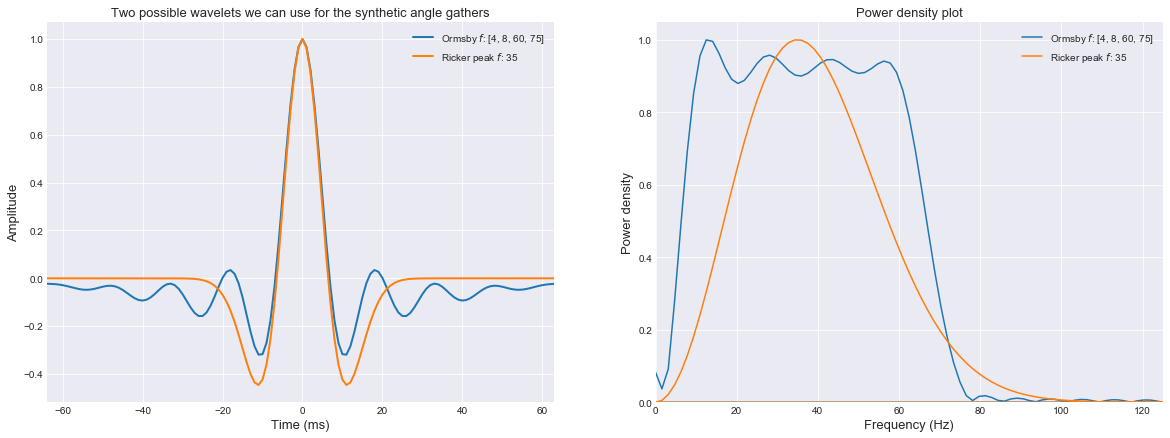

In [19]:
sns.set_style(style="darkgrid")

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
ax0.plot(t_basis * 1e3, wvlt_orm, label = f'Ormsby $f$: {f_arr}', linewidth=2)
ax0.plot(t_basis * 1e3, wvlt, label = f'Ricker peak $f$: {f}', linewidth=2)
ax1.plot(freqs, power_spec_ormsby, label = f'Ormsby $f$: {f_arr}')
ax1.plot(freqs, power_spec_ricker, label= f'Ricker peak $f$: {f}')
ax0.set_xlabel('Time (ms)', size=13)
ax0.set_ylabel('Amplitude', size=13)
ax0.set_title('Two possible wavelets we can use for the synthetic angle gathers', size=13)
ax0.set_xlim(t_basis.min() * 1e3,t_basis.max() * 1e3)
ax1.set_title('Power density plot', size=13)
ax1.set_ylabel('Power density', size=13)
ax1.set_xlabel('Frequency (Hz)', size=13)
ax1.set_xlim(0, 125)
ax1.set_ylim(0,)
ax0.legend()
ax1.legend(loc=1)

# The fun part
This is an interactive plot which will allow you to edit different parameters and see the affect they have on the seismic response. Just click **Run Interact** to generate a new plot after you change parameters.

You can select either of the wavelets plotted above. If you wish to change the parameters of one of the wavelets, scroll to the top of the page, click to make the code visible, and then edit the inputs. You can change things like wavelet length and frequency content.


| Variable    | Description |
| -------------|:------------| 
|**wavelet** 			|	Either 'ormsby' or 'ricker'                                                                    |
|**gain** 				|	A constant multiplier to make the pre-stack amplitudes easier to see (for display only)        |
|**res_thickness** 		|	Thickness of the fluid sub interval in meters                                                  |
|**vp, vs, rhob InSitu**| 	The rock properties of the reservoir you will be doign the fluid substitution to               |
|**vp, vs, rhob Encase**| 	The background rock encasing the reservoir formation                                           |
|**P** 					|	Pressure (in Mpa)                                                                              |
|**T** 					|	Temperature (in degrees C)                                                                     |
|**API** 				|	API gravity for the oil substitution                                                           |
|**G** 					|	Gas gravity for gas substitution and for the live oil calcuation                               |
|**S** 					|	Salinity in weight fraction (i.e. ppm/1e6 so 3.5 % brine = 35,000 ppm = 0.035 weight fraction) | 
|**Rg** 				|	The dissolved gas ratio for live oil (unites of Liter/Liter)                                   |
|**grain_den**			|	The grain density used for the density porosity calculation                                    |


Experiement with different values:

* What direction on the IG cross-plot does the rock move if you change the fluid properties?
* What direction does it move if you change the porosity?
* etc.

In [35]:
interact_manual(gassman_plot,continuous_update=False,
                wavelet=Dropdown(options=['ricker', 'ormsby'], value='ricker'),
                gain=IntSlider(max=100, min=1, value=45),
                res_thickness=IntSlider(max=100, min=0, value=75),
                vpInSitu=FloatSlider(max=4500., min=1500., value=3550.),
                vsInSitu=FloatSlider(max=3000., min=400., value=1900.),
                rhobInSitu=FloatSlider(max=2650., min=1650., value=2200.),
                vpEncase=FloatSlider(max=4500., min=1500., value=3300.),
                vsEncase=FloatSlider(max=3000., min=400., value=1500.),
                rhobEncase=FloatSlider(max=2650., min=1650., value=2400.),
                P=FloatSlider(max=140, min=10, value=100),
                T=FloatSlider(max=180, min=28, value=85.5),
                API=FloatSlider(max=70, min=1, value=35),
                G=FloatSlider(max=1.8, min=0.2, value=0.637, step=0.001, readout_format='.3f'),
                S=FloatSlider(max=0.35, min=0.0, value=0.088, step=0.001, readout_format='.3f'),
                Rg=IntSlider(max=20000, min=50, value=50, step=50),
                grain_den=IntSlider(max=2870, min=2640, value=2640)
               )

interactive(children=(Dropdown(description='wavelet', options=('ricker', 'ormsby'), value='ricker'), IntSlider…

<function __main__.gassman_plot>